In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [5]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.neural_net import MODEL_SAVER_ID

from pcloud_benchmark.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, point_cloud_generator,\
leaky_relu, mlp_discriminator

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
save_model = False
do_training = True
save_synthetic_samples = np.hstack([np.array([1,5,10]), np.arange(50, 2001, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/'

In [46]:
n_pc_points = 2048
max_epochs = 2000
arch_tag = 'test'

leak = 0.2
dropout_prob = None

discriminator = mlp_discriminator
adaptive_training = None

beta = 0.2
disc_kwargs = {'non_linearity': leaky_relu(leak),  'dropout_prob': dropout_prob, 'b_norm': False}

generator = point_cloud_generator

gen_kwargs = {'b_norm': False, 'layer_sizes':[64, 128, 256, 512, 1024], 'dropout_prob': dropout_prob}

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_points) +  '_pts'

In [47]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

Loading test data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/test.txt
679 pclouds were loaded. They belong in 1 shape-classes.
Loading train data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt
5761 pclouds were loaded. They belong in 1 shape-classes.
Loading val data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt
338 pclouds were loaded. They belong in 1 shape-classes.


In [48]:
training_data = in_data['train']

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
init_lr = 0.0001

n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [ ]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_points, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3654535500899605, 0.71319510055624924) 26.5127270222


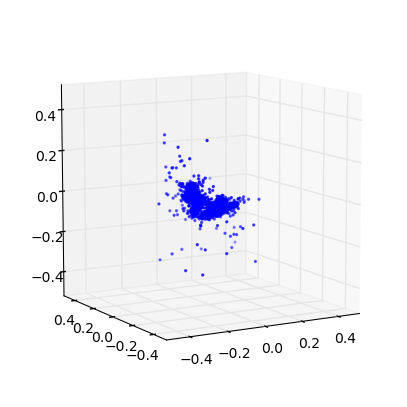

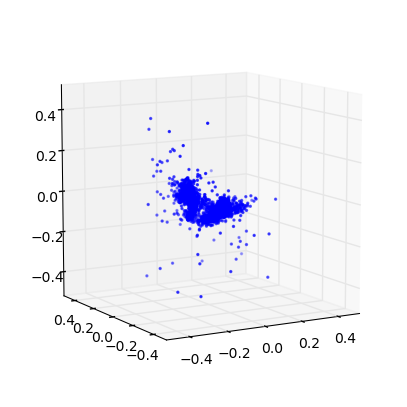

2 (1.331591242292653, 0.74696177814317788) 26.6652009487
3 (1.2154257763987002, 0.9098060089608897) 26.4862258434
4 (1.1401205384212991, 1.1092100848322328) 27.1265711784
5 (1.1053560034088465, 1.1070117053778274) 26.68415308


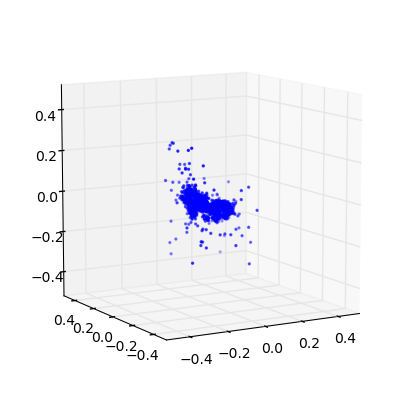

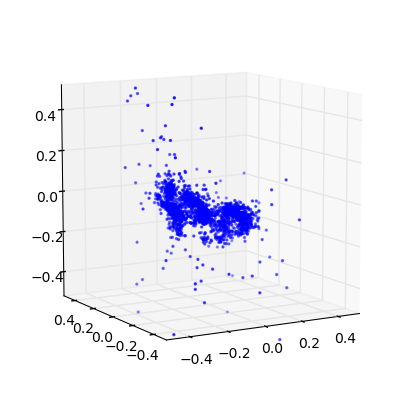

6 (1.4061479920926301, 0.81337136652158659) 26.9265780449
7 (1.3054060282914535, 0.76887694700904519) 26.7701408863
8 (1.2905067557873933, 0.79238553669141687) 26.9473450184
9 (1.2596534107042396, 0.83340100879254553) 27.2242538929
10 (1.2820213297139043, 0.87778252104054322) 26.6181049347


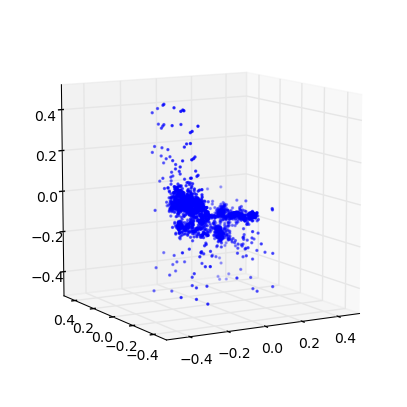

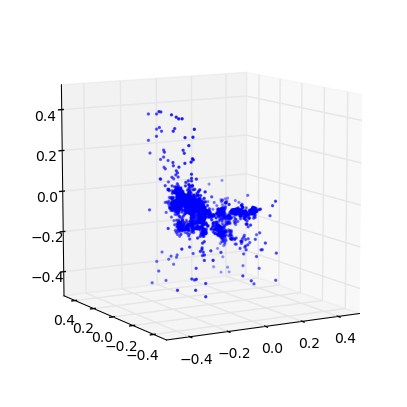

11 (1.266406664641007, 0.87112136664597883) 26.7531659603
12 (1.2780288063961527, 0.83222039782482649) 27.0489211082
13 (1.3019377293794052, 0.80566158372422925) 27.2910609245
14 (1.301033065630042, 0.81505876416745393) 27.4629158974
15 (1.2776860838351043, 0.83391774296760557) 27.1219990253
16 (1.2602284638778023, 0.85216330212095515) 27.7045149803
17 (1.2678786692412003, 0.85918266669563625) 27.1598050594
18 (1.2716548857481584, 0.84579412444778113) 27.0606861115
19 (1.3126224061717158, 0.80940131804217463) 27.0065779686
20 (1.3254492925560992, 0.79142399378444839) 27.3522810936
21 (1.3365331121112989, 0.7866828402747279) 27.1273610592
22 (1.3254194373669832, 0.78699028258738313) 27.0207271576
23 (1.3100368157677029, 0.80141103423160054) 27.2964110374
24 (1.3172935610232146, 0.79116333308427234) 26.9938759804
25 (1.3227266052494879, 0.78641359650570408) 27.3682279587
26 (1.316410117563994, 0.79218829999799312) 27.5570089817
27 (1.3161449307980744, 0.78459512306296308) 29.9727039337
2

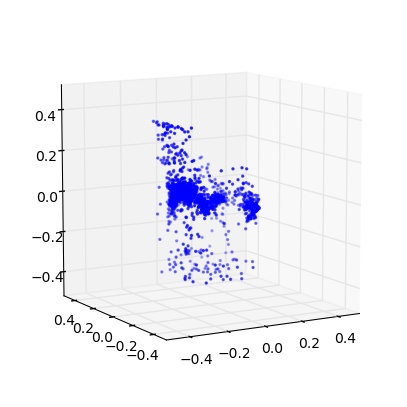

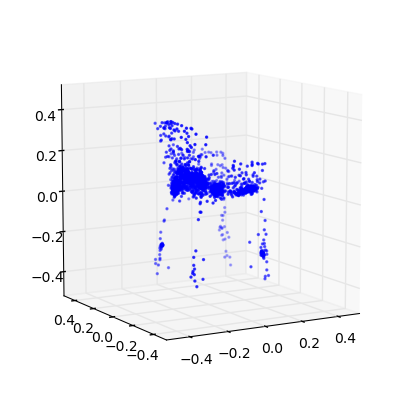

51 (1.3624882438908452, 0.74196003053499304) 27.5378549099
52 (1.3616762181986932, 0.74654785446498706) 26.6349010468
53 (1.3622176232545271, 0.74329517561456426) 26.7750310898
54 (1.3600063479464988, 0.74356376295504367) 26.9288320541
55 (1.3636255513066831, 0.74621863727984217) 26.8592638969
56 (1.3625393535779871, 0.7427293440570002) 26.907738924
57 (1.366386610528697, 0.74353927918102425) 26.7255461216
58 (1.3653220985246741, 0.74561105189116106) 26.7034478188
59 (1.3668015065400496, 0.74514174772345498) 26.7433280945
60 (1.3602866514869358, 0.74333333813625835) 26.8192710876
61 (1.3600523751714955, 0.74326794665792717) 26.7957401276
62 (1.3626931200856749, 0.74194565855938455) 26.85079813
63 (1.3615733644236689, 0.74493293217990708) 26.7089262009
64 (1.3578985680704532, 0.74498486156048982) 26.499204874
65 (1.3604452661845996, 0.74481963696687115) 27.0437788963
66 (1.3625536535097205, 0.74576688408851621) 26.6537218094
67 (1.357691857089167, 0.74021273903224782) 26.8117208481
68 (

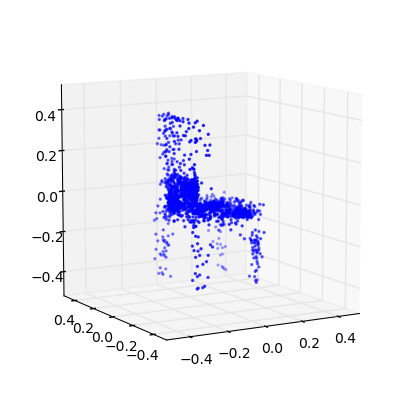

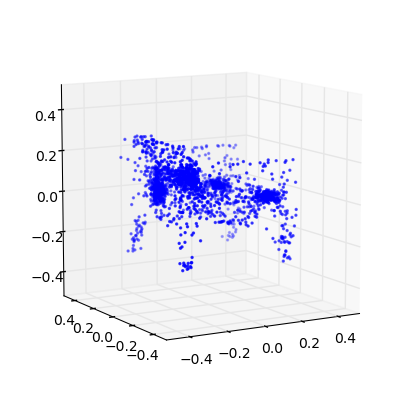

101 (1.3593798336775407, 0.7453426889751269) 26.5445868969
102 (1.3582077669060748, 0.74490366241206296) 26.6306200027
103 (1.3599956585013349, 0.74704454515291296) 26.657886982
104 (1.3634193721024885, 0.74492584570594456) 26.7156429291
105 (1.357944709321727, 0.74207131447999375) 26.8336498737
106 (1.36297171426856, 0.74301165808802061) 26.5640690327
107 (1.3628213726955911, 0.74695570468902583) 26.6190218925
108 (1.3657389174336974, 0.74370990913847224) 26.6724059582
109 (1.3672803505607274, 0.74217433618462603) 26.6490929127
110 (1.362000182400579, 0.74222873034684556) 26.6056909561
111 (1.3663985438968824, 0.74519308442654819) 26.5277070999
112 (1.3638880159543909, 0.74144430886144219) 26.7989919186
113 (1.3624277042305988, 0.74311639588812128) 26.6184949875
114 (1.3624584996181985, 0.74624411852463435) 26.5122640133
115 (1.3609507716220357, 0.74684121401413628) 26.7566640377
116 (1.3626429796218873, 0.74467237047527146) 26.5190219879
117 (1.3618600420329883, 0.7425422637358956) 2

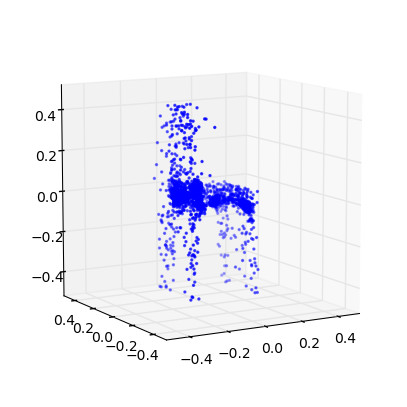

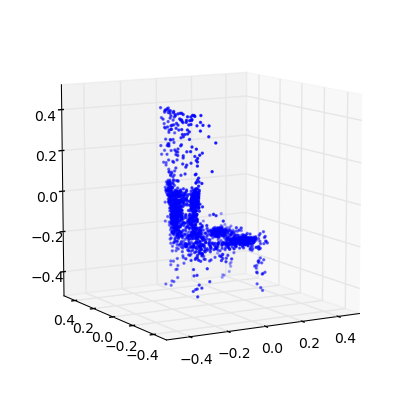

151 (1.3669643536857936, 0.74536415701327119) 27.4103159904
152 (1.3612514951954717, 0.74980778279511828) 27.4197070599
153 (1.3653910927150561, 0.74822421436724451) 27.3943741322
154 (1.3642182319060616, 0.74971443984819497) 27.4307918549
155 (1.3619408617848936, 0.74613762523816984) 27.4772949219
156 (1.3648494834485261, 0.74936544998832366) 27.4352529049
157 (1.3612337506335714, 0.74554625075796377) 27.4595310688
158 (1.3629052659739618, 0.74823419011157488) 27.4299471378
159 (1.3618763477905937, 0.74916016226229465) 27.425994873
160 (1.3586905666019606, 0.74851620560107024) 27.4327011108
161 (1.3603130008863367, 0.74457635050234583) 27.4086151123
162 (1.3629732629527216, 0.74573483881743063) 28.9649510384
163 (1.3625880023707515, 0.74467990294746733) 27.3553669453
164 (1.3650194157724795, 0.74581158057503083) 27.3721551895
165 (1.3644626710725867, 0.7449624574702719) 27.3383071423
166 (1.3676188614057458, 0.74782854474109151) 27.3327729702
167 (1.3621996703355208, 0.747067321901736

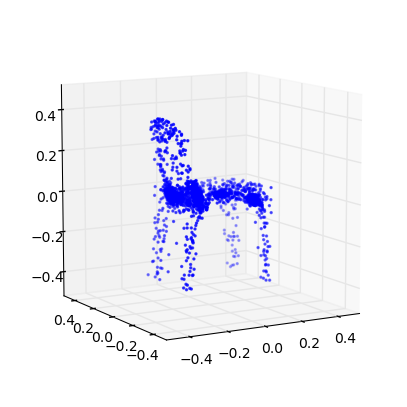

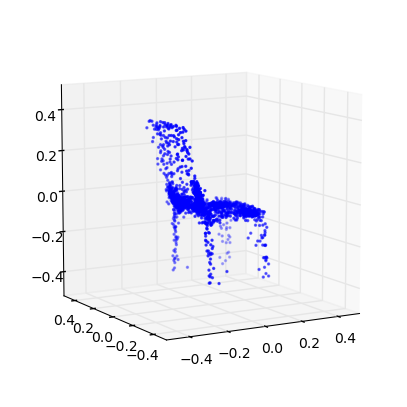

201 (1.3591860968133678, 0.75669076650039013) 27.3423259258
202 (1.3608036963836005, 0.75097652207250176) 27.3167700768
203 (1.3587162038554317, 0.75582362413406368) 27.3266131878
204 (1.3574423624121625, 0.75493645097898399) 27.3994009495
205 (1.3583918270857438, 0.75169074379879497) 27.4007461071
206 (1.3610718053320179, 0.75495292311129358) 27.4121289253
207 (1.3617843389511108, 0.75811788569325989) 27.4537189007
208 (1.355302297550699, 0.75429637846739395) 27.3959238529
209 (1.357885688284169, 0.75573399585226309) 27.4081509113
210 (1.3600392040999039, 0.75602973025778064) 27.3503549099
211 (1.3589642016784005, 0.75453615033108257) 27.3487160206
212 (1.3574261665344238, 0.75436995858731482) 27.3240380287
213 (1.3596342988636183, 0.7524345947348553) 27.3445849419
214 (1.357291351193967, 0.75729018035142315) 27.3463580608
215 (1.3548670084580132, 0.75604420952174978) 27.3330919743
216 (1.3599831798802251, 0.75759022598681247) 27.3401069641
217 (1.3586143794267074, 0.7560708014861397)

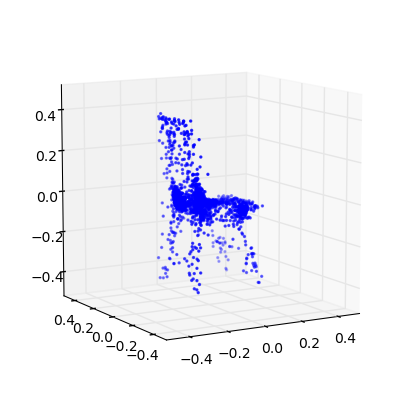

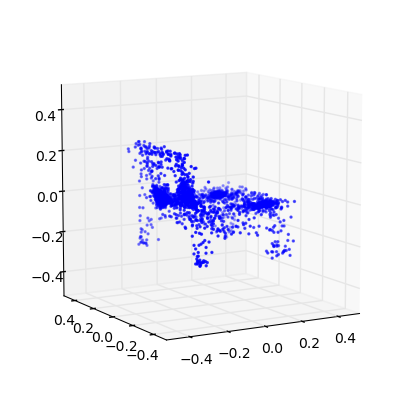

251 (1.3528809702914695, 0.76606687100037285) 27.352918148
252 (1.3497614663580189, 0.76105471693951154) 27.3875300884
253 (1.3497531828672991, 0.76464396715164185) 27.3914880753
254 (1.3490274450053339, 0.7715692794841269) 27.3345179558
255 (1.3440328888271167, 0.7723842040352199) 27.3679339886
256 (1.3480457844941511, 0.77371993427691255) 27.3602359295
257 (1.3440139635749486, 0.77485884946325556) 27.3674199581
258 (1.3473774412403936, 0.77684402362160065) 27.3849389553
259 (1.3459183102068695, 0.77534485485242766) 27.372918129
260 (1.3449980870537135, 0.77737755671791409) 27.4710040092
261 (1.3484035740727964, 0.77612226113029148) 27.3786408901
262 (1.3456768149914948, 0.77160456336062888) 27.3594889641
263 (1.3442024210224981, 0.77049048465231196) 27.3671779633
264 (1.347141166355299, 0.7775008186050083) 27.3944191933
265 (1.3441980735115382, 0.77361050222230998) 27.3711550236
266 (1.3443759555402008, 0.77361625121987387) 27.3730728626
267 (1.3456080364144367, 0.77763964300570276) 

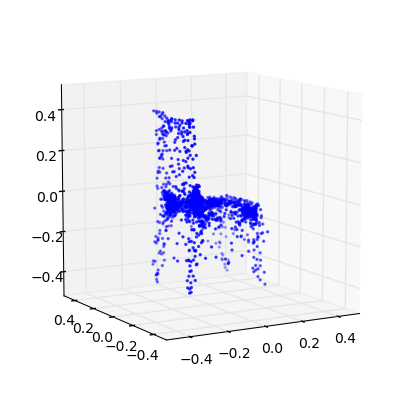

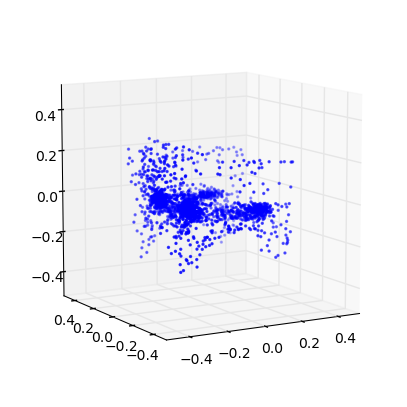

301 (1.3446232070093569, 0.78403222457222321) 26.4481270313
302 (1.3435304341108902, 0.77646946077761447) 26.5177760124
303 (1.3431838325832202, 0.7795991679896479) 26.4376459122
304 (1.3456291571907375, 0.78046251379925269) 26.7458600998
305 (1.3398812604987103, 0.781166020165319) 26.508646965
306 (1.3445155993751858, 0.77672433801319285) 26.4754219055
307 (1.3425027339354805, 0.77684793472290037) 26.47625494
308 (1.3458275587662407, 0.77687344499256294) 26.6456639767
309 (1.3499154464058254, 0.77934741922046824) 26.4571578503
310 (1.3461449975552766, 0.77517159710759698) 26.5542168617
311 (1.349506744094517, 0.77926264172014981) 26.574737072
312 (1.3424514998560366, 0.77562430941540261) 26.4472780228
313 (1.3455022169196087, 0.77803929007571682) 26.6923141479
314 (1.3472129324208135, 0.77790235799291862) 26.5777590275
315 (1.3435570996740589, 0.77928767929906428) 26.5601990223
316 (1.3501228301421455, 0.77745666970377381) 26.7615740299
317 (1.3475226816923722, 0.77789633377738621) 26

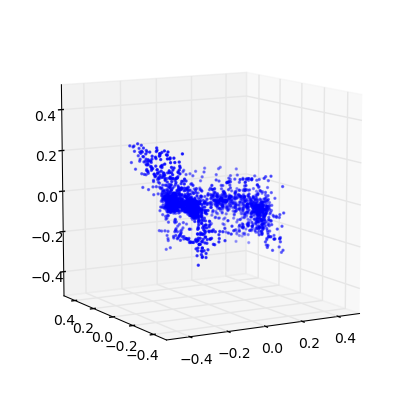

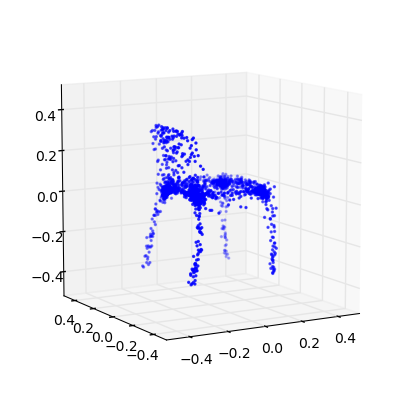

351 (1.3351658655249554, 0.78468854997469029) 26.4640388489
352 (1.337893127358478, 0.7853036833846051) 26.4887609482
353 (1.3394927563874617, 0.79053310415019162) 26.4887199402
354 (1.335448515933493, 0.78916937786599861) 26.6257770061
355 (1.3366689557614533, 0.78695547477058747) 26.4762599468
356 (1.3412085678266443, 0.78851074809613431) 26.5491950512
357 (1.3378889208254607, 0.79192145389059321) 26.4836950302
358 (1.3357636970022451, 0.78754137858100559) 26.6773579121
359 (1.3358021020889281, 0.79117888575014861) 26.4892840385
360 (1.3317616815152375, 0.79121850936309146) 26.6494560242
361 (1.3303272579027259, 0.79298665368038679) 26.4814450741
362 (1.3335104040477588, 0.79752808912940643) 26.5937409401
363 (1.3318916517755259, 0.7961118387139362) 26.519972086
364 (1.3299312114715576, 0.79661279916763306) 26.5616850853
365 (1.3285387215406999, 0.79598948281744253) 26.4430549145
366 (1.3328578793484231, 0.79600846352784527) 26.7053129673
367 (1.3341055517611295, 0.79437973499298098)

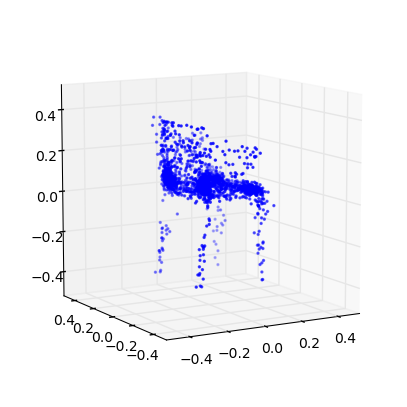

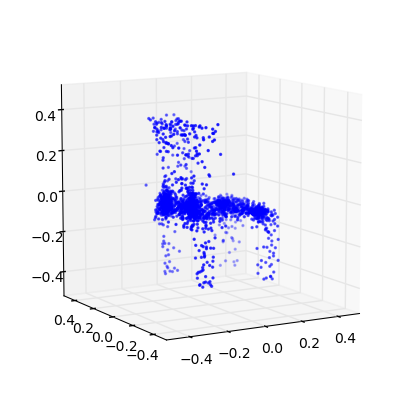

401 (1.332548677402994, 0.79719807946163679) 26.5026731491
402 (1.3259931833847709, 0.79705634531767477) 26.434472084
403 (1.3333793857823248, 0.79875764587651132) 26.7399668694
404 (1.3278935878173164, 0.80394656450852109) 26.6354300976
405 (1.3277776365694793, 0.8020698246748551) 26.5914928913
406 (1.3260661850804869, 0.79923075437545776) 26.614333868
407 (1.3268439500228217, 0.80190339088439944) 26.594408989
408 (1.3287877943204798, 0.80699952944465303) 26.5078959465
409 (1.3199816579404084, 0.79866589981576674) 26.5816690922
410 (1.3222557192263396, 0.8019870872082917) 26.5193347931
411 (1.3266352187032284, 0.80584078716195151) 26.4608409405
412 (1.3266613784043686, 0.80940200712369836) 26.6566359997
413 (1.3225743438886559, 0.80949489914852635) 26.5006279945
414 (1.3150509886119677, 0.80832941272984382) 26.562967062
415 (1.3201849242915278, 0.81078112021736481) 26.4860570431
416 (1.3260670858880748, 0.81191599369049072) 26.5073471069
417 (1.3223166818204133, 0.80020959740099695) 2

In [ ]:
save_syn_data_dir = create_dir(osp.join(synthetic_data_out_dir, experiment_name))

if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            
        if epoch in save_synthetic_samples:
            syn_data = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_data)
            np.savez(osp.join(save_syn_data_dir, 'epoch_' + str(epoch)), syn_data)            
            for k in range(2):
                Point_Cloud(syn_data[k]).plot()
#         train_stats.append((epoch,) + loss)

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

In [ ]:
epoch_to_check = 1500
n_check = 5
check_data = accum_syn_data[(epoch_to_check / 10)-1]
rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
for i in range(n_check):
    Point_Cloud(check_data[rids[i]]).plot(in_u_sphere=True)    

In [ ]:
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/'
saver_step = 10
if save_synthetic_samples:    
    create_dir(save_dir)
    for i, d in enumerate(accum_syn_data):
        epoc = str((i + 1) * saver_step)
        np.savez(osp.join(save_dir, 'epoch_' + epoc), d)